In [1]:
!nvidia-smi

Sat Jul 18 20:41:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size=64

In [5]:
transform = transforms.Compose([
        transforms.ToTensor()])

In [6]:
#mnist data
train_dataset = torchvision.datasets.MNIST(root='data/mnist',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/mnist',
                                          train=False, 
                                          transform=transform)
#put into batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [7]:
class autoencoder(nn.Module):
  def __init__(self,n_clus):
    super(autoencoder,self).__init__()
    self.encoder1 = nn.Sequential(
                nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1), 
                nn.BatchNorm2d(64),
                nn.Sigmoid())
    self.encoder2 =  nn.Sequential(
                nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1), 
                nn.BatchNorm2d(64),
                nn.Sigmoid())
    self.encoder3 =  nn.Sequential(
                nn.Conv2d(64,1,kernel_size=3,stride=1,padding=1), 
                nn.BatchNorm2d(1),
                nn.Sigmoid())
    self.encoder4 = nn.Sequential(
                nn.Conv2d(1,1,kernel_size=2,stride=2,padding=0), 
                nn.BatchNorm2d(1),
                nn.Sigmoid())
    self.decoder4 = nn.Sequential(
                nn.ConvTranspose2d(1,1,kernel_size=2,stride=2,padding=0), 
                nn.BatchNorm2d(1),
                nn.Sigmoid())
    self.decoder3 = nn.Sequential(
                nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1), 
                nn.BatchNorm2d(64),
                nn.Sigmoid()
                )
    self.decoder2 =  nn.Sequential(
                nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1), 
                nn.BatchNorm2d(64),
                nn.Sigmoid())
    self.decoder1 = nn.Sequential(
                nn.Conv2d(64,1,kernel_size=3,stride=1,padding=1), 
                nn.BatchNorm2d(1),
                nn.Sigmoid())
    self.n_clus = n_clus
    self.em = nn.Linear(14*14,self.n_clus)
  def forward(self,x):
    enc1 = self.encoder1(x)
    enc2 = self.encoder2(enc1)
    enc3 = self.encoder3(enc2)
    enc4 = self.encoder4(enc3)
    dec4 = self.decoder4(enc4)
    dec3 = self.decoder3(dec4)
    dec2 = self.decoder2(dec3)
    dec1 = self.decoder1(dec2)
    x = enc4.view(-1, 14*14)
    em = self.em(x)
    em = F.softmax(em, dim=1)
    return (enc1,enc2,enc3,enc4,dec4,dec3,dec2,dec1,em)
  def obtain_batch_loss(self,x,beta):
    enc1,enc2,enc3,enc4,dec4,dec3,dec2,dec1,em=self.forward(x)
    loss1 = nn.BCELoss()(dec1,x)
    loss2 = nn.MSELoss()(dec2,enc1)
    loss3 = nn.MSELoss()(dec3,enc2)
    loss4 = nn.MSELoss()(dec4,enc3)
    r_sumoveri = torch.sqrt(torch.sum(em,dim=0))
    num = em/r_sumoveri   
    q = num/(torch.sum(num,dim=0))
    clus_loss = -1*torch.mean(q*torch.log(em))/self.n_clus
    recons_loss = loss1+beta*(loss2+loss3+loss4)
    return (clus_loss,recons_loss)
  def encode(self,x):
    enc1 = self.encoder1(x)
    enc2 = self.encoder2(enc1)
    enc3 = self.encoder3(enc2)
    enc4 = self.encoder4(enc3)
    return enc4



In [8]:
autoenc = autoencoder(10).to(device)

In [9]:
optim = torch.optim.Adam(autoenc.parameters())

In [10]:
epochs=20

In [11]:
for epoch in range(epochs):
    minloss = 1
    running_clus_loss=0
    running_recons_loss=0
    num_images=0
    for i,(img,_) in enumerate(train_loader):
      img = img.to(device)
      optim.zero_grad()
      clus_loss,recons_loss = autoenc.obtain_batch_loss(img,0.8)
      loss=recons_loss+clus_loss
      loss.backward()
      optim.step()
      running_clus_loss = running_clus_loss + clus_loss.item()*len(img)
      running_recons_loss = running_recons_loss + recons_loss.item()*len(img)
      num_images= num_images+len(img)
    print('epoch: '+str(epoch)+' clus_loss: '+str(running_clus_loss/num_images)+' recons_loss: '+str(running_recons_loss/num_images))



epoch: 0 clus_loss: 0.0023629308170328538 recons_loss: 0.380856663719813
epoch: 1 clus_loss: 0.0010372992645949126 recons_loss: 0.19061184738477072
epoch: 2 clus_loss: 0.0007880701465532183 recons_loss: 0.13141564782063167
epoch: 3 clus_loss: 0.0006811727010955413 recons_loss: 0.10500081599553426
epoch: 4 clus_loss: 0.0006076119801340004 recons_loss: 0.0907700130780538
epoch: 5 clus_loss: 0.0005498430259525776 recons_loss: 0.0822585394581159
epoch: 6 clus_loss: 0.0004884579785168171 recons_loss: 0.07668576671679815
epoch: 7 clus_loss: 0.00043796065185839933 recons_loss: 0.07283904890219371
epoch: 8 clus_loss: 0.00040747800592022635 recons_loss: 0.07033924849828084
epoch: 9 clus_loss: 0.00037673767536568144 recons_loss: 0.06877936117649078
epoch: 10 clus_loss: 0.0003644357221511503 recons_loss: 0.06768387426535288
epoch: 11 clus_loss: 0.00034593339598116776 recons_loss: 0.06697604223489761
epoch: 12 clus_loss: 0.0003316517922095954 recons_loss: 0.06643760021924973
epoch: 13 clus_loss: 0

In [12]:
encd=np.array([])
imgs=np.array([])
labels=np.array([])
for i,(img,label) in enumerate(train_loader):
  encoded = autoenc.encode(img.to(device)).cpu().detach()
  if(i==0):
    encd=np.array(encoded)
    imgs=np.array(img)
    labels=np.array(label)
  else:
    encd = np.concatenate([encd,np.array(encoded)])
    imgs = np.concatenate([imgs,np.array(img)])
    labels = np.concatenate([labels,np.array(label)])
print(imgs.shape)
print(encd.shape)
print(labels.shape)

(60000, 1, 28, 28)
(60000, 1, 14, 14)
(60000,)


In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=700)
tsne_results = tsne.fit_transform(imgs.reshape(60000,28*28)[:5000])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.439s...
[t-SNE] Computed neighbors for 5000 samples in 37.007s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.334313
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.897369
[t-SNE] KL divergence after 700 iterations: 1.523341


In [17]:
tsne_2d_one = tsne_results[:,0]
tsne_2d_two = tsne_results[:,1]

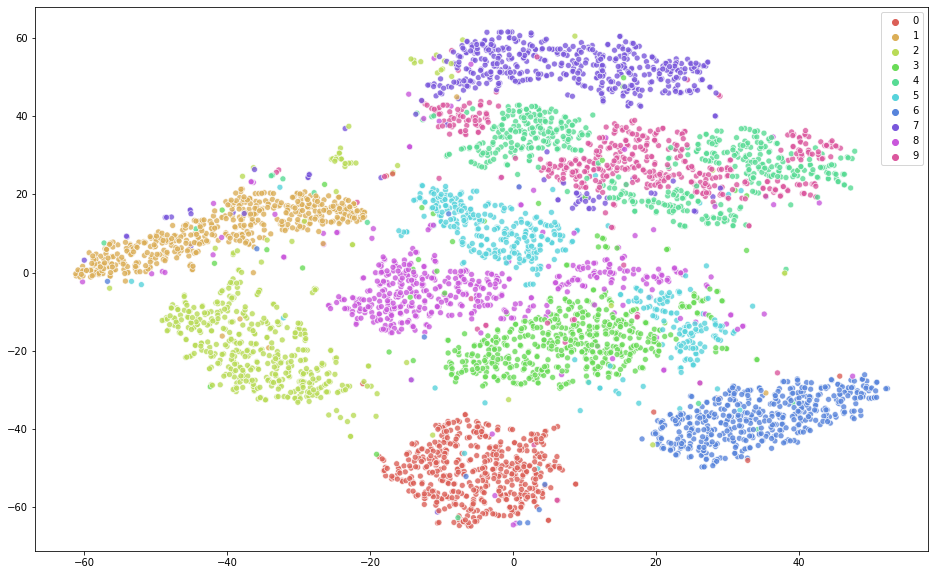

In [18]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_2d_one, y=tsne_2d_two,
    hue=labels[:5000],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.8
)

In [19]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=700)
tsne_results = tsne.fit_transform(encd.reshape(60000,14*14)[:5000])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.082s...
[t-SNE] Computed neighbors for 5000 samples in 9.699s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.561298
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.753410
[t-SNE] KL divergence after 700 iterations: 1.385582


In [20]:
tsne_2d_one = tsne_results[:,0]
tsne_2d_two = tsne_results[:,1]

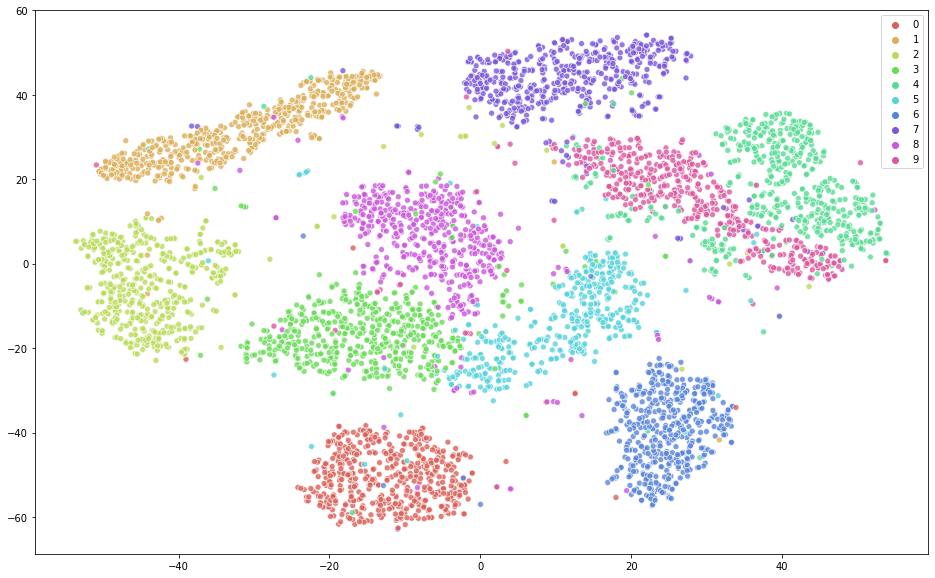

In [21]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_2d_one, y=tsne_2d_two,
    hue=labels[:5000],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.8
)